In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Headers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally

import healpy as hp

from astropy.io import fits
from astropy.table import Table, Column

import treecorr

import os

from scipy.optimize import curve_fit

In [3]:
# can also be done just by reading the normal txt file instead of the fits file

NSIDE = 2048

print('Pixel scale [arcmins] = ', np.sqrt(hp.nside2pixarea(NSIDE, degrees = True)*3600))

Pixel scale [arcmins] =  1.7177432059087028


# Phase correlations and order parameter

## Gaussian map

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<Figure size 864x864 with 0 Axes>

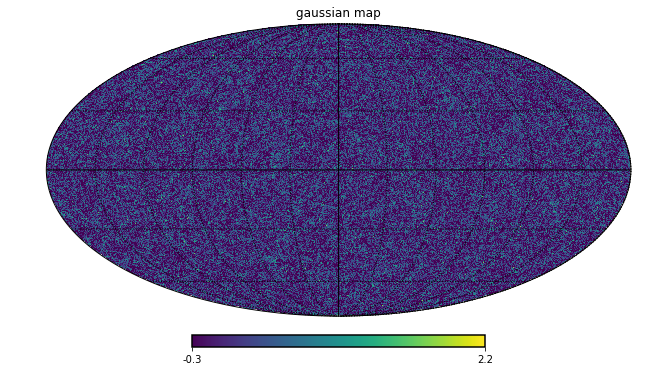

In [4]:
map_idx = 1
map_type = 'gaussian'
filepath = './simulations_output/'+map_type+'_maps/'
density_field = hp.fitsfunc.read_map(filepath+map_type+'_map_'+str(map_idx)+'.fits')

plt.figure(figsize=(12,12))
hp.mollview(density_field, min=-0.3, max=2.2, title=map_type+' map')
hp.graticule()

Text(0.5, 1.0, 'Histogram of pixel values of the gaussian map')

/home/anik/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/anik/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


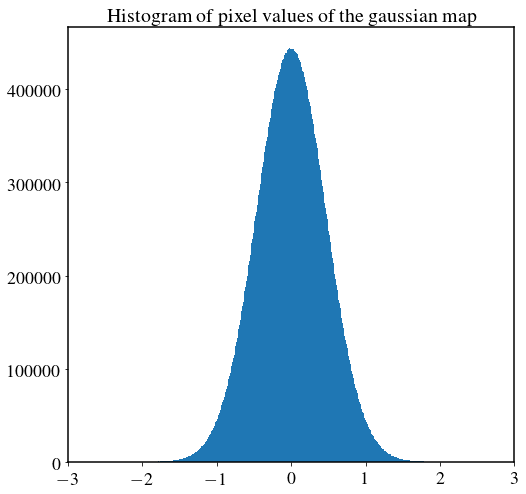

In [5]:
plt.figure(figsize=(8,8))
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)
plt.hist(density_field, bins = 500);
plt.xlim(-3,3)
plt.title('Histogram of pixel values of the '+map_type+' map', fontsize=20)

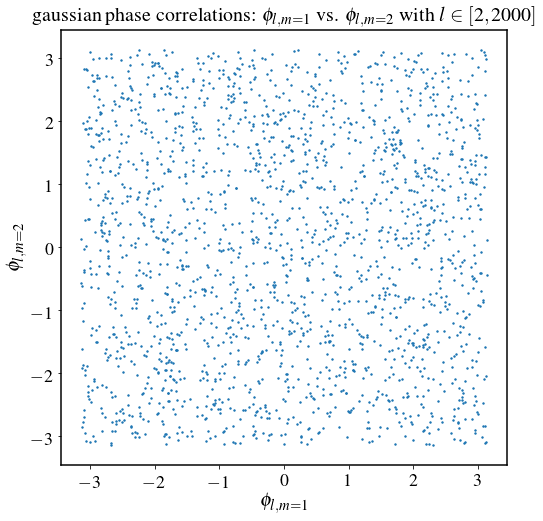

In [6]:
recov_alm = np.loadtxt(filepath+'/recov_alm_'+str(map_idx)+'.dat')
recovCls = np.loadtxt(filepath+'/recovCls_'+str(map_idx)+'.dat')

phi_lm = np.arctan2(recov_alm[:,3],recov_alm[:,2])

phi_lm_x = np.zeros(recovCls[:,0].size)
phi_lm_y = np.zeros(recovCls[:,0].size)

l_array = recovCls[:,0].astype('int')

# m = 1 vs m = 2
for l in l_array:
    if (l == 1):
        phi_lm_x[l-1] = np.float('NaN')
        phi_lm_y[l-1] = np.float('NaN')
        prev_l_m0_idx = 0
    else: 
        phi_lm_x[l-1] = phi_lm[prev_l_m0_idx+l+1] # m = 1
        phi_lm_y[l-1] = phi_lm[prev_l_m0_idx+l+2] # m = 2
        prev_l_m0_idx += l
        
"""
# m = 1 vs m = 3
for l in l_array:
    if (l == 1 or l == 2):
        phi_lm_x[l-1] = np.float('NaN')
        phi_lm_y[l-1] = np.float('NaN')
        prev_l_m0_idx = 2
    else: 
        phi_lm_x[l-1] = phi_lm[prev_l_m0_idx+l+1] # m = 1
        phi_lm_y[l-1] = phi_lm[prev_l_m0_idx+l+3] # m = 3
        prev_l_m0_idx += l
"""

plt.figure(figsize=(8,8))
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)

plt.scatter(phi_lm_x, phi_lm_y, s=2)
plt.xlabel('$\phi_{l,m=1}$',fontsize=20)
plt.ylabel('$\phi_{l,m=2}$',fontsize=20)
plt.title(map_type+' phase correlations: $\phi_{l,m=1}$ vs. $\phi_{l,m=2}$ with $l \\in [2,2000]$', fontsize=20)
plt.savefig('./plots/phase_correlations_'+map_type+'.png')

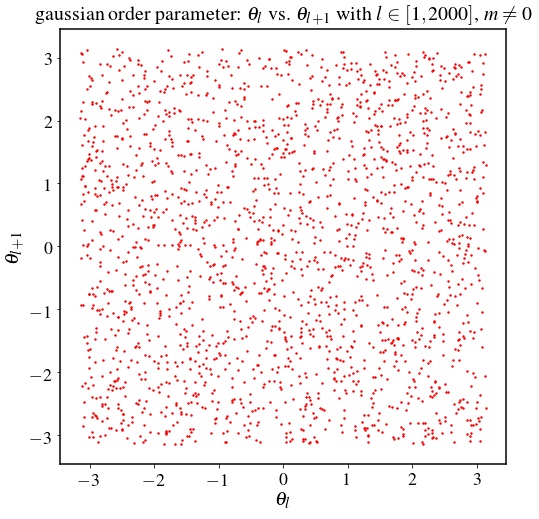

In [7]:
l_m0_idx_arr = np.zeros(recovCls[:,0].size).astype('int')

idx = 0
for l in l_array:
    l_m0_idx_arr[l-1] = idx
    for j in range(l+1):
        #print(str(l)+'  '+str(j)+'  '+'  '+str(l_m0_idx_arr[l-1]))
        idx += 1    

order_parameter_l_Re = np.zeros(recovCls[:,0].size)
order_parameter_l_Im = np.zeros(recovCls[:,0].size)

for l in l_array[:]:
    if (l == l_array[-1]):
        order_parameter_l_Re[l-1] = np.sum(recov_alm[l_m0_idx_arr[l-1]+1:,2])
        order_parameter_l_Im[l-1] = np.sum(recov_alm[l_m0_idx_arr[l-1]+1:,3])
    else:
        order_parameter_l_Re[l-1] = np.sum(recov_alm[l_m0_idx_arr[l-1]+1:l_m0_idx_arr[l],2])
        order_parameter_l_Im[l-1] = np.sum(recov_alm[l_m0_idx_arr[l-1]+1:l_m0_idx_arr[l],3])

order_parameter_l_phi = np.arctan2(order_parameter_l_Im, order_parameter_l_Re)

plt.figure(figsize=(8,8))
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)

plt.scatter(order_parameter_l_phi[:-1],order_parameter_l_phi[1:], s=2, c='r')
plt.xlabel('$\\theta_{l}$',fontsize=20)
plt.ylabel('$\\theta_{l+1}$',fontsize=20)
plt.title(map_type+' order parameter: $\\theta_{l}$ vs. $\\theta_{l+1}$ with $l \\in [1,2000]$, $m\\neq0$', fontsize=20)
plt.savefig('./plots/order_parameter_'+map_type+'.png')

## Lognormal map

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/anik/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 864x864 with 0 Axes>

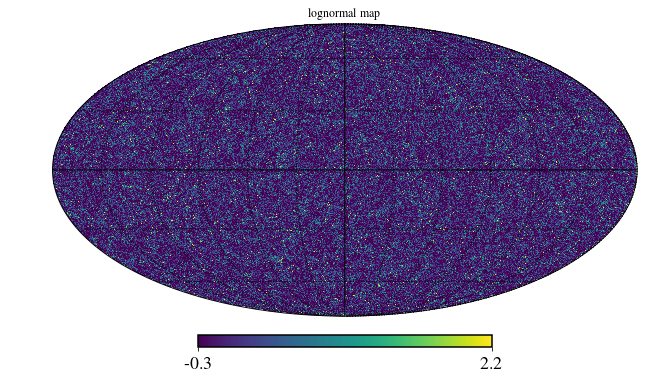

In [8]:
map_idx = 1
map_type = 'lognormal'
logshift = 1.0
filepath = './simulations_output/'+map_type+'_maps/logshift_'+str(logshift)+'/'
density_field = hp.fitsfunc.read_map(filepath+map_type+'_map_'+str(map_idx)+'.fits')

plt.figure(figsize=(12,12))
hp.mollview(density_field, min=-0.3, max=2.2, title=map_type+' map')
hp.graticule()

Text(0.5, 1.0, 'Histogram of pixel values of the lognormal map')

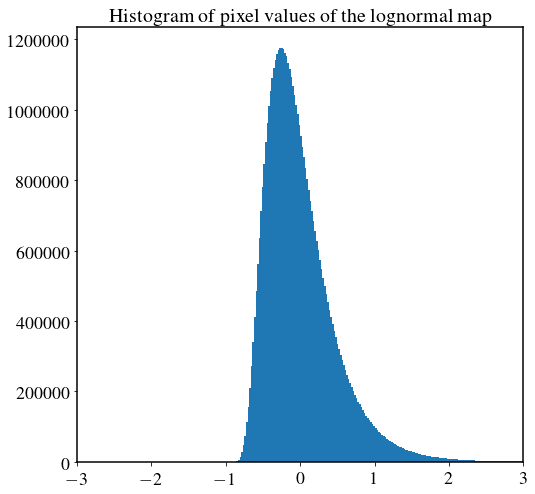

In [9]:
plt.figure(figsize=(8,8))
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)
plt.hist(density_field, bins = 500);
plt.xlim(-3,3)
plt.title('Histogram of pixel values of the '+map_type+' map', fontsize=20)

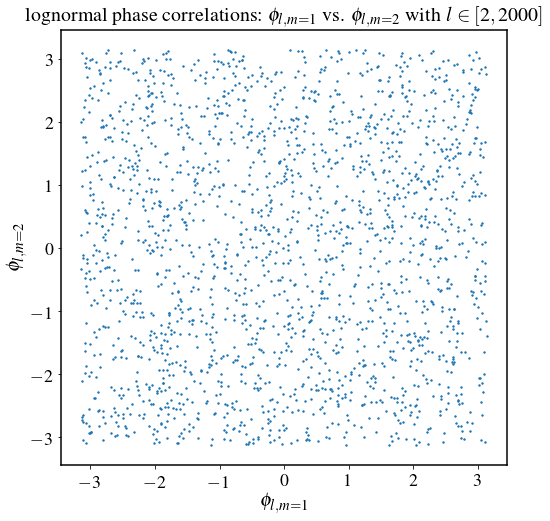

In [10]:
recov_alm = np.loadtxt(filepath+'/recov_alm_'+str(map_idx)+'.dat')
recovCls = np.loadtxt(filepath+'/recovCls_'+str(map_idx)+'.dat')

phi_lm = np.arctan2(recov_alm[:,3],recov_alm[:,2])

phi_lm_x = np.zeros(recovCls[:,0].size)
phi_lm_y = np.zeros(recovCls[:,0].size)

l_array = recovCls[:,0].astype('int')
        
# m = 1 vs m = 2
for l in l_array:
    if (l == 1):
        phi_lm_x[l-1] = np.float('NaN')
        phi_lm_y[l-1] = np.float('NaN')
        prev_l_m0_idx = 0
    else: 
        phi_lm_x[l-1] = phi_lm[prev_l_m0_idx+l+1] # m = 1
        phi_lm_y[l-1] = phi_lm[prev_l_m0_idx+l+2] # m = 2
        prev_l_m0_idx += l
        
"""
# m = 1 vs m = 3
for l in l_array:
    if (l == 1 or l == 2):
        phi_lm_x[l-1] = np.float('NaN')
        phi_lm_y[l-1] = np.float('NaN')
        prev_l_m0_idx = 2
    else: 
        phi_lm_x[l-1] = phi_lm[prev_l_m0_idx+l+1] # m = 1
        phi_lm_y[l-1] = phi_lm[prev_l_m0_idx+l+3] # m = 3
        prev_l_m0_idx += l
"""
        
plt.figure(figsize=(8,8))
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)

plt.scatter(phi_lm_x, phi_lm_y, s=2)
plt.xlabel('$\phi_{l,m=1}$',fontsize=20)
plt.ylabel('$\phi_{l,m=2}$',fontsize=20)
plt.title(map_type+' phase correlations: $\phi_{l,m=1}$ vs. $\phi_{l,m=2}$ with $l \\in [2,2000]$', fontsize=20)
plt.savefig('./plots/phase_correlations_'+map_type+'.png')

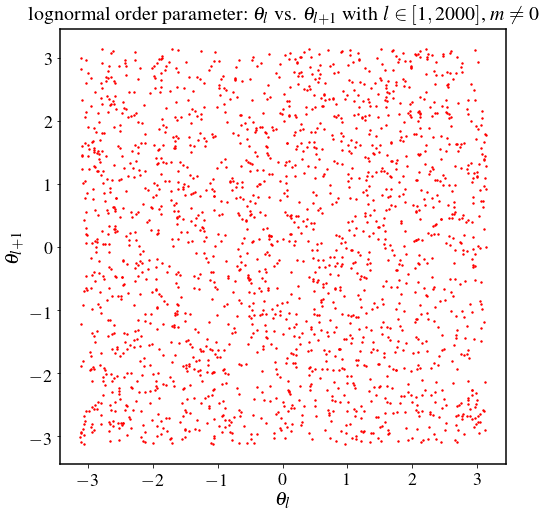

In [11]:
l_m0_idx_arr = np.zeros(recovCls[:,0].size).astype('int')

idx = 0
for l in l_array:
    l_m0_idx_arr[l-1] = idx
    for j in range(l+1):
        #print(str(l)+'  '+str(j)+'  '+'  '+str(l_m0_idx_arr[l-1]))
        idx += 1    

order_parameter_l_Re = np.zeros(recovCls[:,0].size)
order_parameter_l_Im = np.zeros(recovCls[:,0].size)

for l in l_array[:]:
    if (l == l_array[-1]):
        order_parameter_l_Re[l-1] = np.sum(recov_alm[l_m0_idx_arr[l-1]+1:,2])
        order_parameter_l_Im[l-1] = np.sum(recov_alm[l_m0_idx_arr[l-1]+1:,3])
    else:
        order_parameter_l_Re[l-1] = np.sum(recov_alm[l_m0_idx_arr[l-1]+1:l_m0_idx_arr[l],2])
        order_parameter_l_Im[l-1] = np.sum(recov_alm[l_m0_idx_arr[l-1]+1:l_m0_idx_arr[l],3])

order_parameter_l_phi = np.arctan2(order_parameter_l_Im, order_parameter_l_Re)

plt.figure(figsize=(8,8))
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)

plt.scatter(order_parameter_l_phi[:-1],order_parameter_l_phi[1:], s=2, c='r')
plt.xlabel('$\\theta_{l}$',fontsize=20)
plt.ylabel('$\\theta_{l+1}$',fontsize=20)
plt.title(map_type+' order parameter: $\\theta_{l}$ vs. $\\theta_{l+1}$ with $l \\in [1,2000]$, $m\\neq0$', fontsize=20)
plt.savefig('./plots/order_parameter_'+map_type+'.png')

## Comparison of phase correlations : Gaussian and lognormal

In [12]:
from IPython.display import HTML, display

In [13]:
display(HTML("<table><tr><td><img src='./plots/phase_correlations_gaussian.png'></td><td><img src='./plots/phase_correlations_lognormal.png'></td></tr></table>"))

,


## Comparison of order parameter : Gaussian and lognormal

In [14]:
display(HTML("<table><tr><td><img src='./plots/order_parameter_gaussian.png'></td><td><img src='./plots/order_parameter_lognormal.png'></td></tr></table>"))

,
